# Evaluation spechum, temp vorticity GCMx -> 2.2km-4x over Birmingham

Compare model using spechum, temp and vort850 with one just vort850

## Diff model

No loc-spec params

64x64 pixel target

With stored transforms so CPM-based and GCM-based samples use the same set of transforms computed during training from CPM training set


Input transform: standardize (based on train set mean and std) then devide by standardized train set max

Target transform: sqrt then divide by sqrted train set max

Sample inverse transform: multiply by train set max, clip negative values to 0 then square

In [1]:
%reload_ext autoreload

%autoreload 2

import math
import os

import iris
import iris.analysis.cartography
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from ml_downscaling_emulator import UKCPDatasetMetadata
from ml_downscaling_emulator.helpers import plot_over_ts
from ml_downscaling_emulator.utils import cp_model_rotated_pole, platecarree, plot_grid, prep_eval_data, show_samples, distribution_figure, plot_mean_bias, plot_std, plot_psd

In [2]:
split = "val"

datasets = {
    "CPM": "2.2km-coarsened-gcm-2.2km-coarsened-4x_birmingham_vorticity850_random",
    # "GCM": "60km-2.2km-coarsened-4x_birmingham_vorticity850_random",
}

runs = [
    ("gcmx-4x_bham_vorticity850_random-stored-transforms", 20, "Vort850 only"),
]
vort_ds = prep_eval_data(datasets, runs, split)

In [3]:
datasets = {
    "CPM": "bham_gcmx-4x_spechum-temp-vorticity850_random",
    # "GCM": "bham_60km-4x_spechum-temp-vorticity850_random",
}

runs = [
    ("gcmx-4x_bham_spechum-temp-vorticity850_random-stored-transforms", 20, "Spechum, temp and vort850"),
]
spechum_temp_vort_ds = prep_eval_data(datasets, runs, split)

In [4]:
merged_ds = xr.merge([vort_ds, spechum_temp_vort_ds])

In [5]:
pred_pr = merged_ds["pred_pr"]
target_pr = merged_ds["target_pr"].sel(source="CPM")

total_pred_pr = merged_ds["pred_pr"].mean(dim=["grid_longitude", "grid_latitude"])
total_target_pr = merged_ds["target_pr"].sel(source="CPM").mean(dim=["grid_longitude", "grid_latitude"])

## Samples

In [6]:
sorted_time = total_target_pr.sortby(total_target_pr)["time"].values

Timestep chunk 0

Spechum, temp and vort850

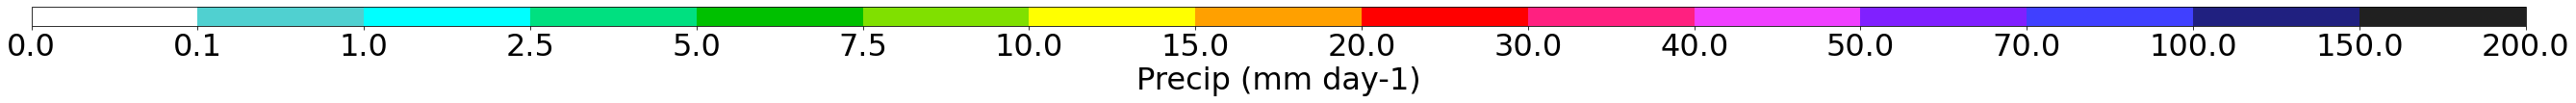

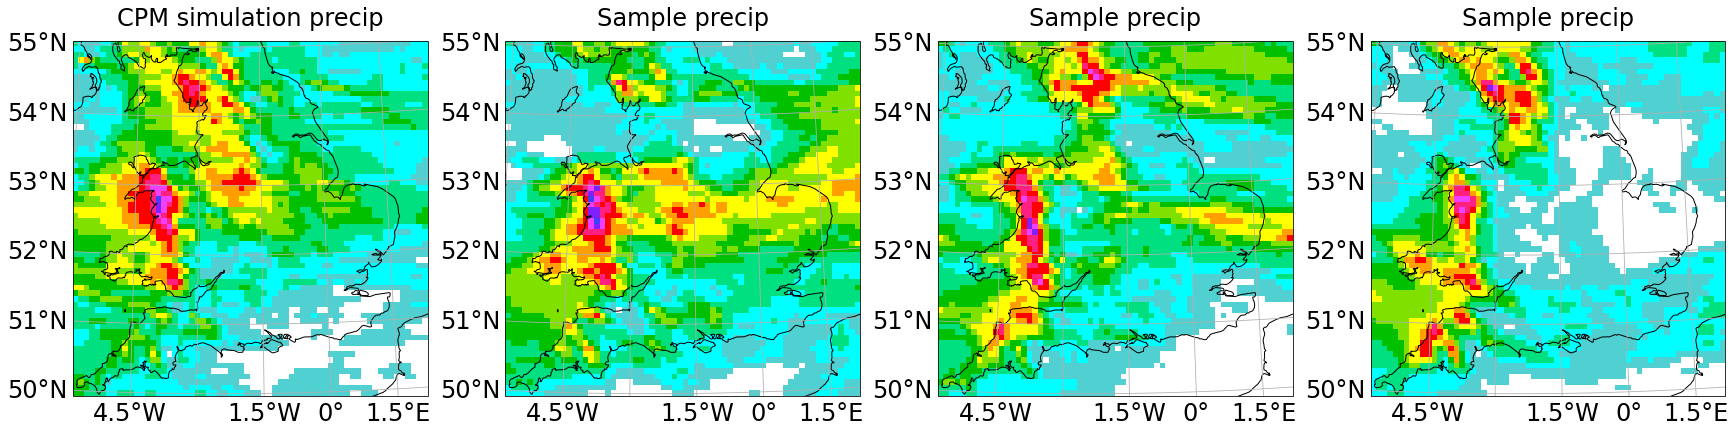

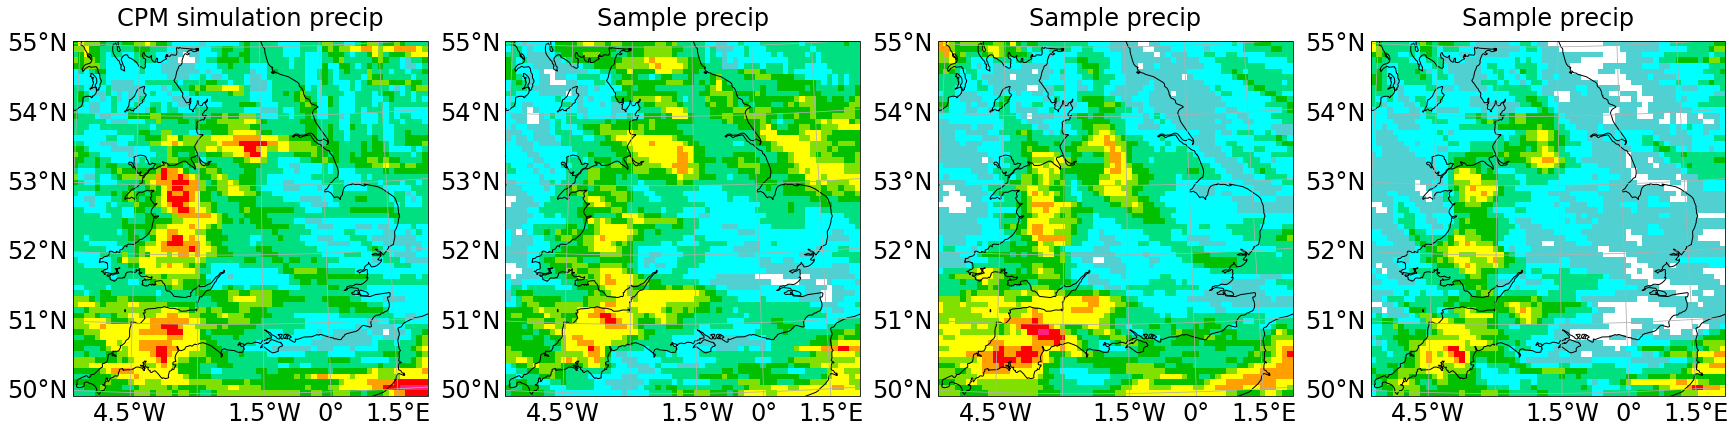

Vort850 only

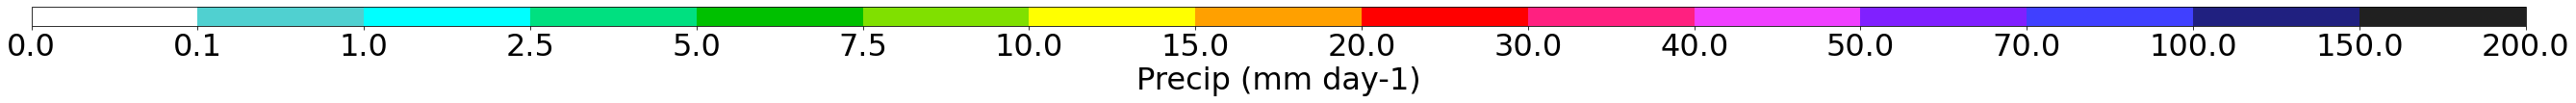

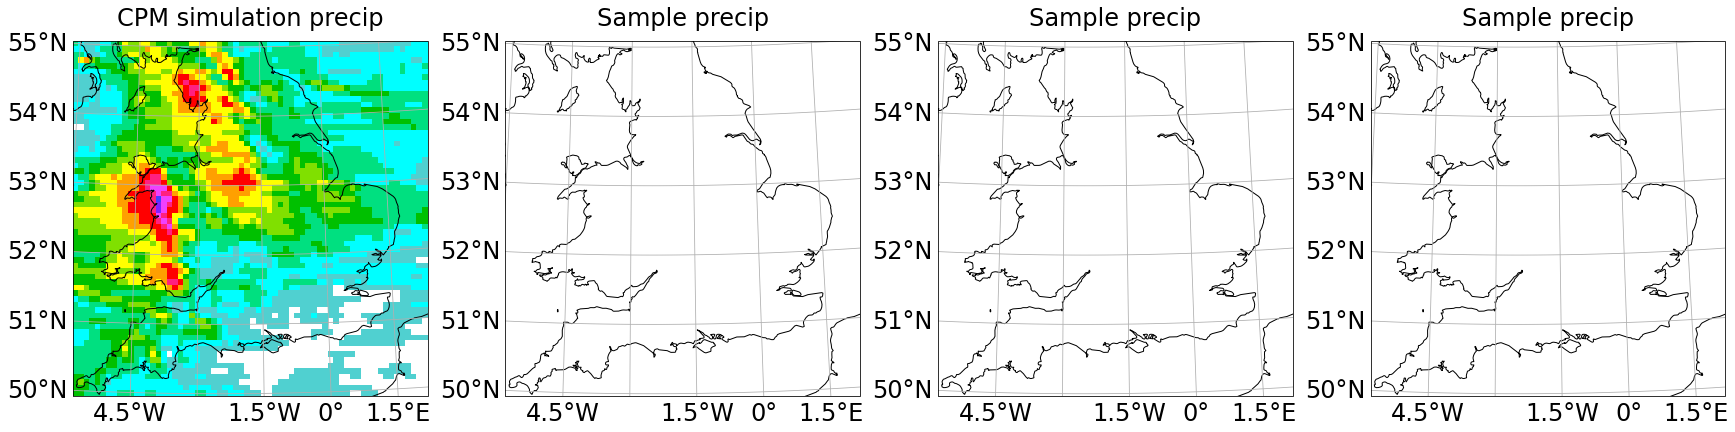

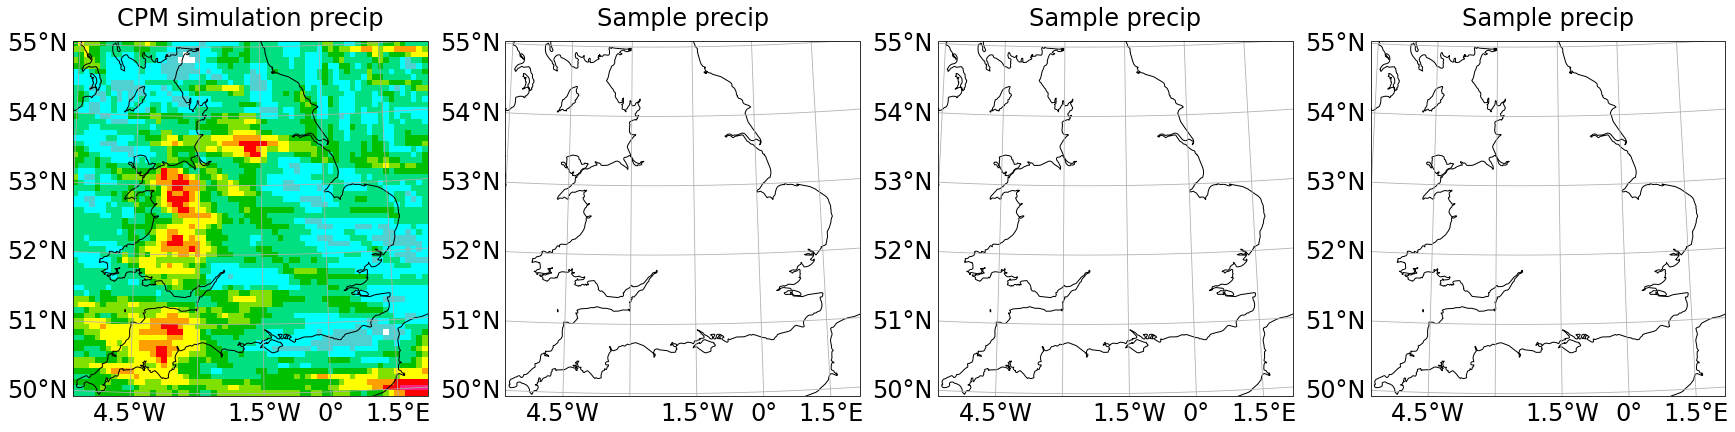

Timestep chunk 1

Spechum, temp and vort850

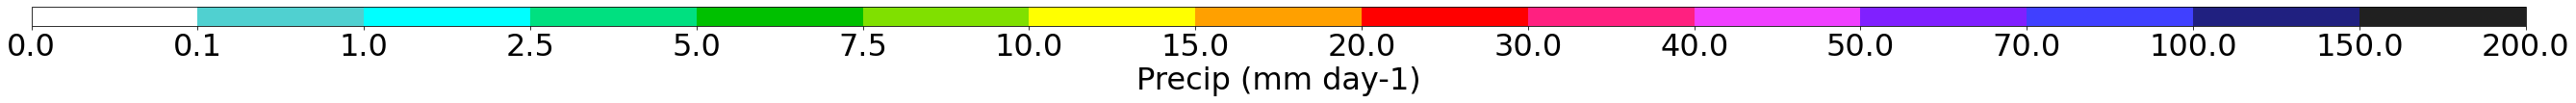

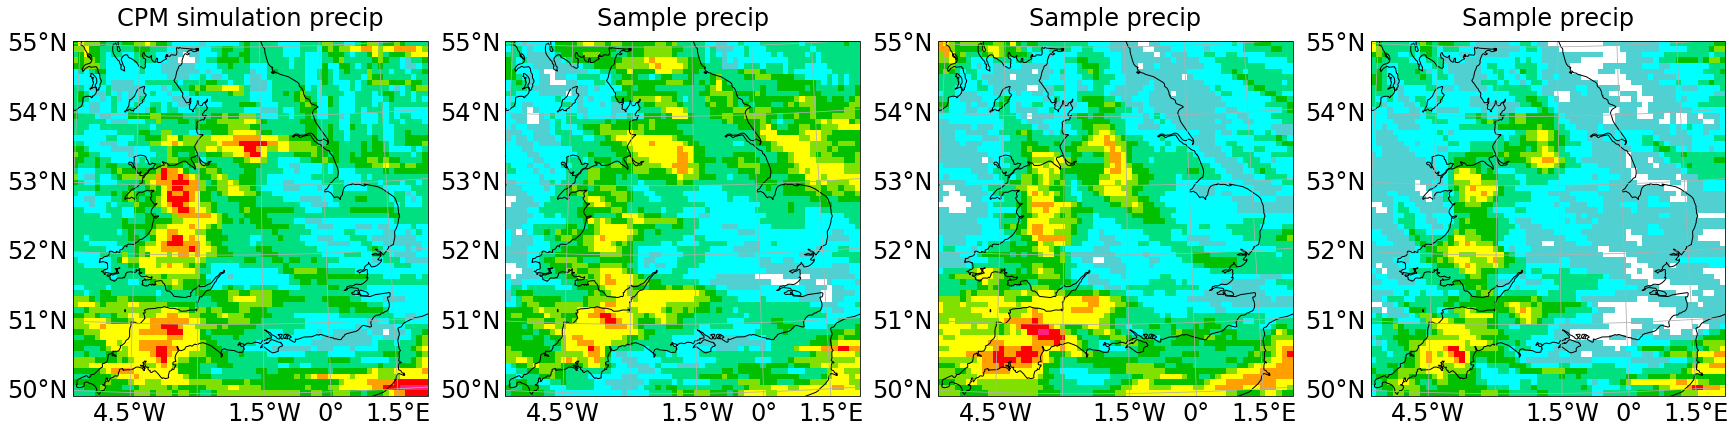

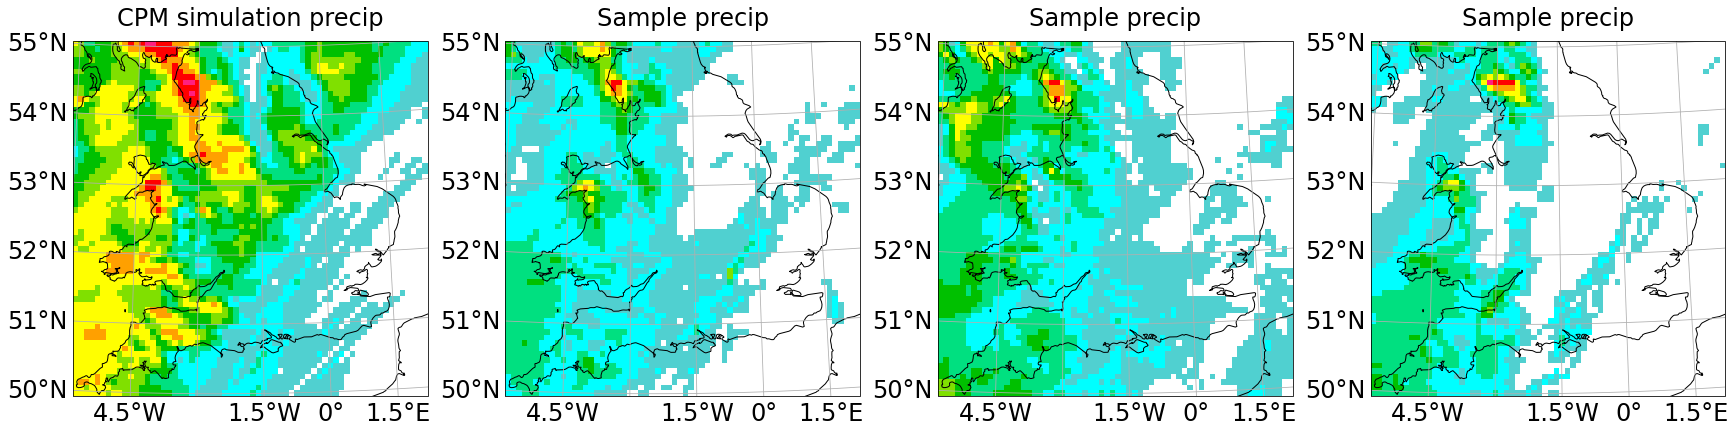

Vort850 only

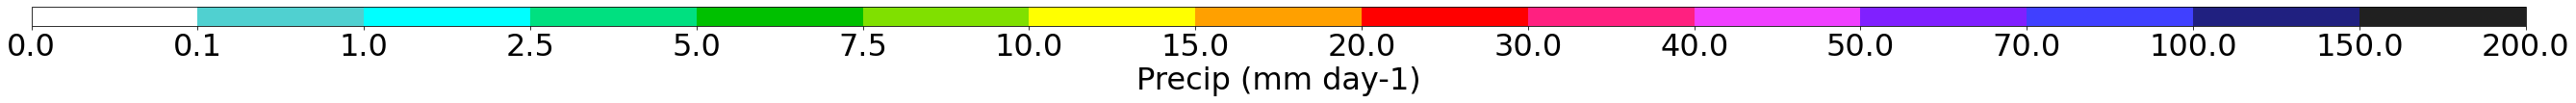

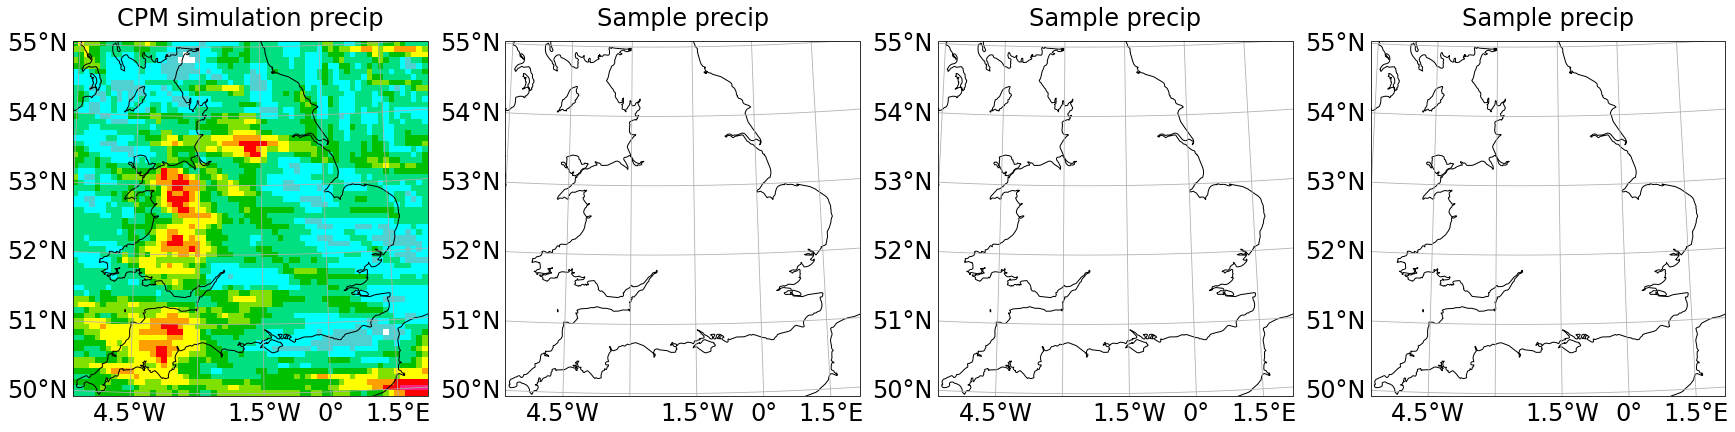

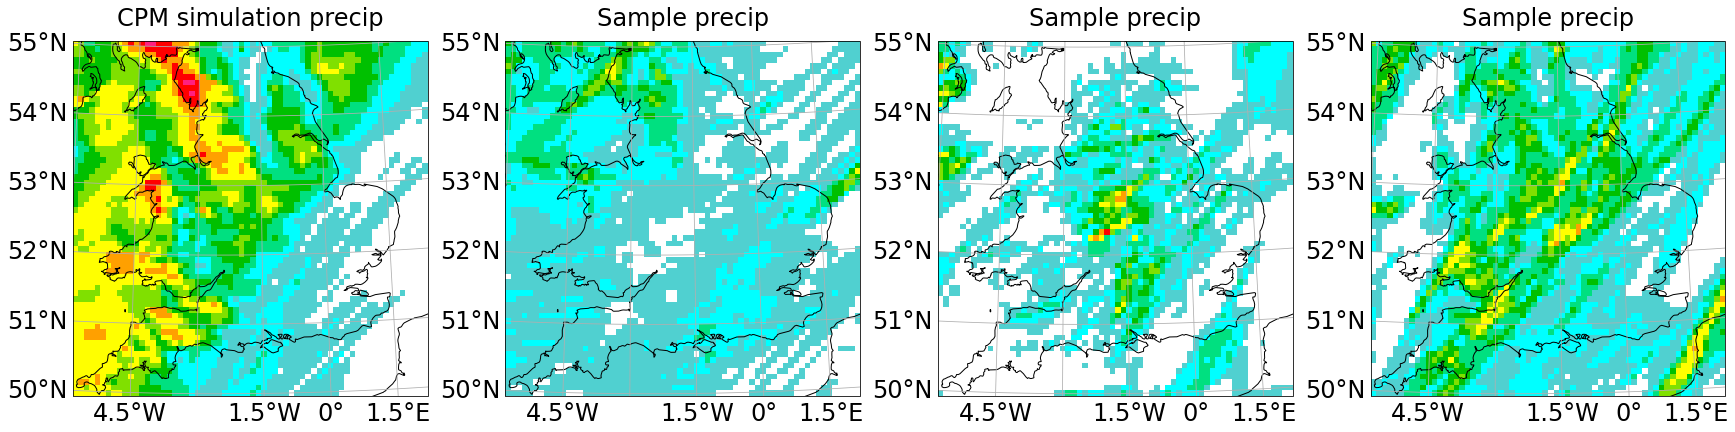

In [7]:
timestamp_chunks = [
    sorted_time[t:t+2] for t in [
        -20, 
        # math.ceil(len(sorted_time)*0.9),
        math.ceil(len(sorted_time)*0.81),
        # math.ceil(len(sorted_time)*0.5), 
        # 17
    ]
]
# timestamps = np.random.choice(sorted_time, size=2*3, replace=False)

for i, timestamps in enumerate(timestamp_chunks):
    IPython.display.display_html(f"<h1>Timestep chunk {i}</h1>", raw=True)
    for model in merged_ds["model"].values:
        IPython.display.display_html(f"<h2>{model}</h2>", raw=True)
        ds = merged_ds.sel(model=model)
        show_samples(ds, timestamps)

## Frequency distribution

### Pixel

CPM

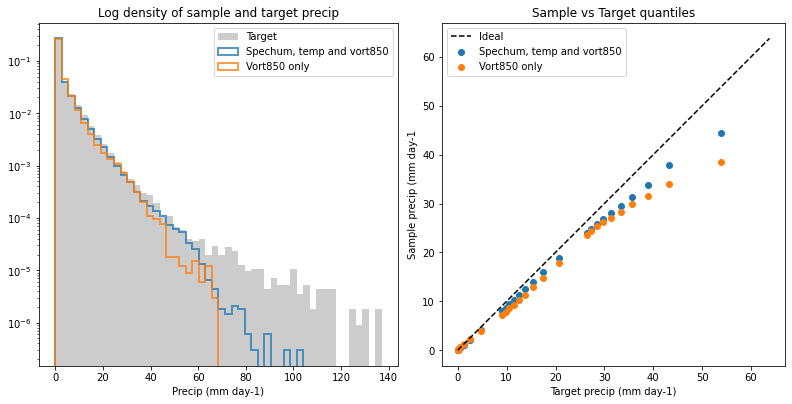

In [8]:
quantiles = np.concatenate([np.linspace(0.1,0.8,8), np.linspace(0.9,0.99,10), np.linspace(0.991,0.999,9)])

for source in pred_pr["source"].values:
    IPython.display.display_html(f"<h1>{source}</h1>", raw=True)
    distribution_figure(target_pr, pred_pr.sel(source=source), quantiles, "Distribution of pixel values")

### Mean over space

CPM

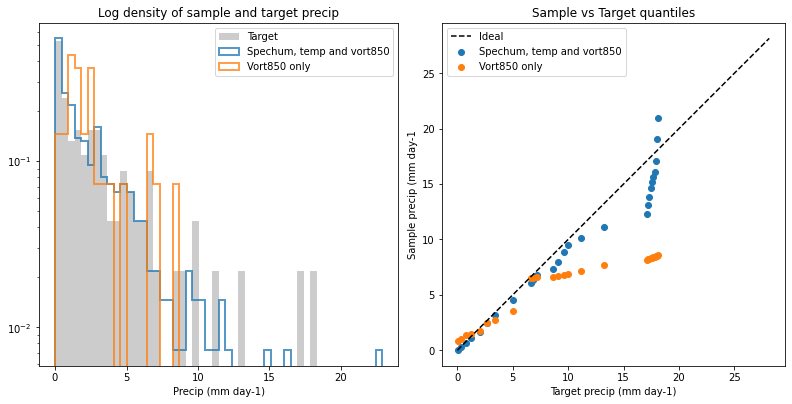

In [9]:
quantiles = np.concatenate([np.linspace(0.1,0.8,8), np.linspace(0.9,0.99,10), np.linspace(0.991,0.999,9)])

for source in total_pred_pr["source"].values:
    IPython.display.display_html(f"<h1>{source}</h1>", raw=True)
    distribution_figure(total_target_pr, total_pred_pr.sel(source=source), quantiles, "Distribution of mean precip over space")

## Bias

CPM

Means

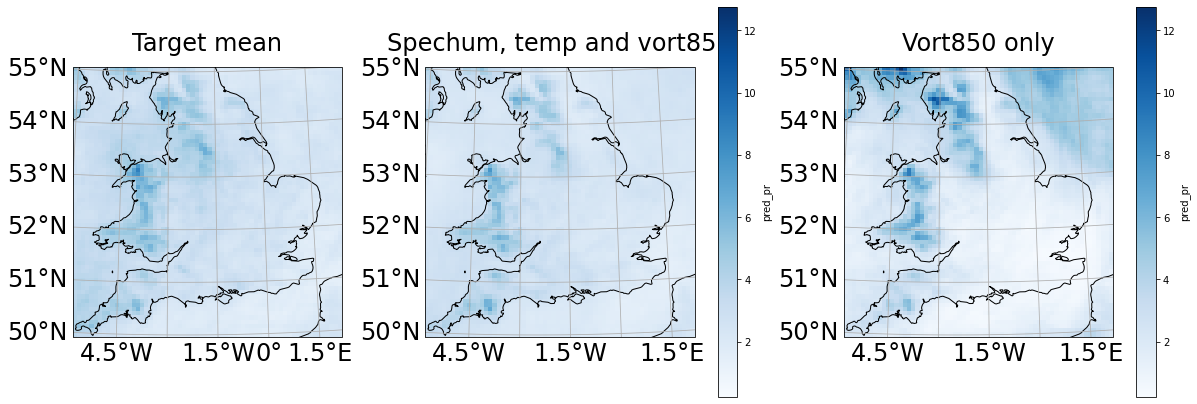

Bias/Target mean

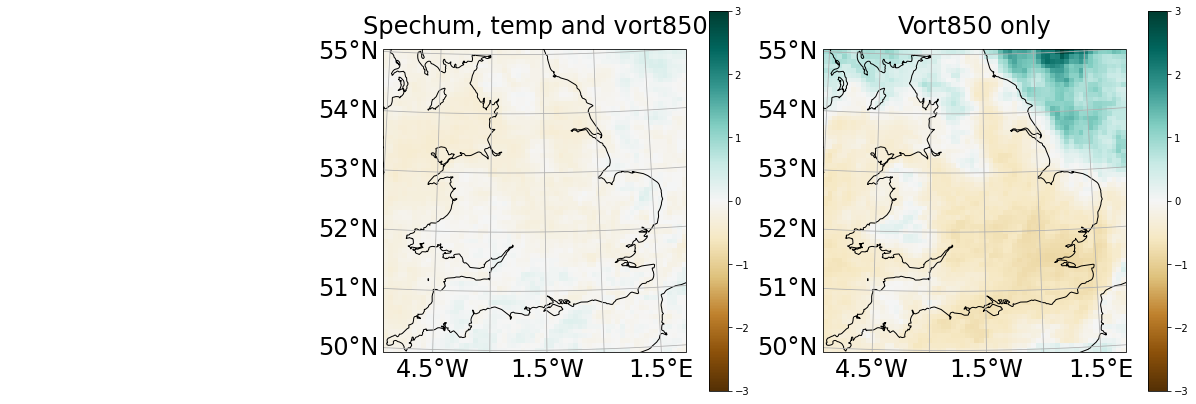

In [10]:
plot_mean_bias(merged_ds)

## Standard deviation

CPM

Spechum, temp and vort850

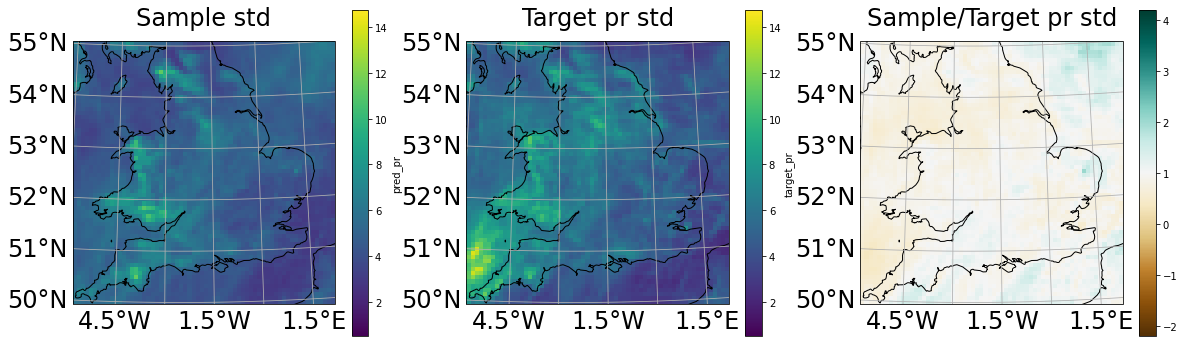

Vort850 only

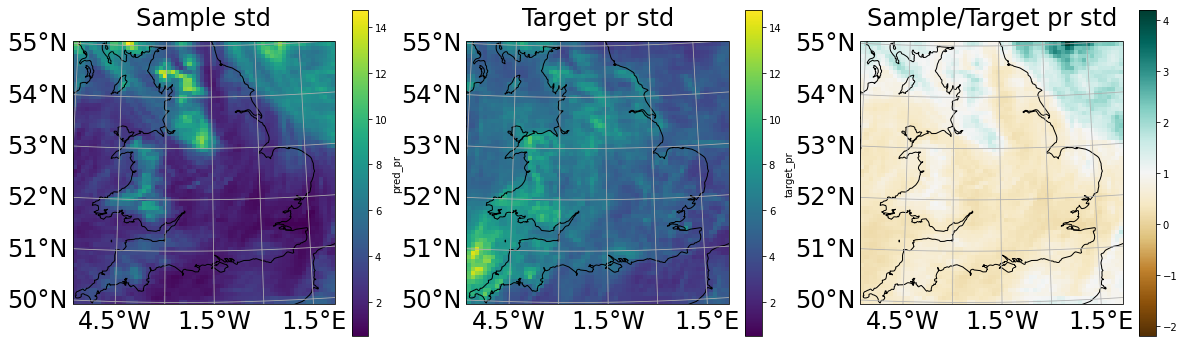

In [11]:
plot_std(merged_ds)

## Scatter

In [12]:
# fig, axs = plt.subplots(1, 1, figsize=(20, 6))

# tr = min(merged_ds["pred_pr"].max(), merged_ds["target_pr"].max())


# ax = axs

# ax.scatter(x=merged_ds["pred_pr"], y=merged_ds["target_pr"].values[None, :].repeat(len(merged_ds["sample_id"]), 0), alpha=0.05)
# ax.plot([0, tr], [0, tr], linewidth=1, color='green')


In [13]:
# sample_ids = np.arange(9).reshape(3, 3)

# fig, axs = plt.subplots(sample_ids.shape[0], sample_ids.shape[1], figsize=(30, 12))

# tr = min(merged_ds["pred_pr"].max(), merged_ds["target_pr"].max())

# for i, sample_id in enumerate(sample_ids.flatten()):
#     ax = axs[i//3][i%3]

#     ax.scatter(x=merged_ds["pred_pr"].sel(sample_id=sample_id), y=merged_ds["target_pr"], alpha=0.1)
#     ax.plot([0, tr], [0, tr], linewidth=1, color='green')
#     ax.set_xlabel(f"Sample {sample_id} pr")
#     ax.set_ylabel(f"Target pr")
    
# plt.show()

In [14]:
# fig, axs = plt.subplots(1, 1, figsize=(20, 6))

# tr = min(total_pred_pr.max(), total_target_pr.max())

# ax = axs

# ax.scatter(x=total_pred_pr, y=total_target_pr.values[None, :].repeat(len(total_pred_pr["sample_id"]), 0), alpha=0.25)
# ax.plot([0, tr], [0, tr], linewidth=1, color='green')

# plt.show()

## PSD

## Correlation